In [1]:
from generate_samples import SyntheticDAG
from causal_peeler_e import *
from causal_peeler import *
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
from tabulate import tabulate
import seaborn as sns

/Users/ryanwelch/opt/anaconda3/envs/causal/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sample_full_rank_matrix(n=3, lower=-10, upper=10):
    while True:
        matrix = torch.FloatTensor(n, n).uniform_(lower, upper)
        matrix.requires_grad_(True)
        matrix.retain_grad()
        if torch.det(matrix).item() != 0:
            return matrix


In [3]:
def max_diff(x, H_diff_sym):
    max_diff = 0.0
    for mat in H_diff_sym:
        val = np.abs(x@mat@x)
        max_diff = max(max_diff, val)
    return max_diff

# Line Graph

In [21]:
DAG_type = 'line'
num_latent = 4
num_samples = 2000
variance_max = 1
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)

In [22]:
# G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
graph = SyntheticDAG(num_latent, DAG_type, variance_max)

In [23]:
U,X=graph.get_obs_samples(G, num_samples, rescale=False)
# U_tr,X_tr =graph.get_obs_samples(G, 100000, rescale=False)

In [17]:
# U_, X_ = graph.get_obs_samples(G, num_samples+100000, rescale=True)
# U = U_[:num_samples,:]
# X = X_[:num_samples,:]
# U_tr = U_[num_samples:,:]
# X_tr = X_[num_samples:,:]
J_X = H_X(graph, U, G).detach().numpy()
X = X.detach().numpy()

In [18]:
# id_layers = identify_e(X, X_tr, estimator='ssm')
id_layers = identify(graph, U, G)
# new_X, leafs, new_J_X = remove_layer(X, J_X)


-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[ 0.81729716  0.42958338  0.33117702 -0.34276097]

No feasible solution found.
Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


No feasible solution found.
Done.

Peeled off 0 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


No feasible solution found.
Done.

Peeled off 0 nodes.
-----------------------------------------------------------
Removing Layer 4.
-----------------------------------------------------------
Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


No feasible solution found.
Done.

Peeled off 0 nodes.
-----------------------------------------------------------
Removing Layer 5.
-----------------------------------------------------------
Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[ 0.          0.62364987 -0.73117763]

No feasible solution found.
Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 6.
-----------------------------------------------------------
Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[ 0.72798177 -0.74235627]

No feasible solution found.
Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 7.
-----------------------------------------------------------
Peeled off 1 nodes.


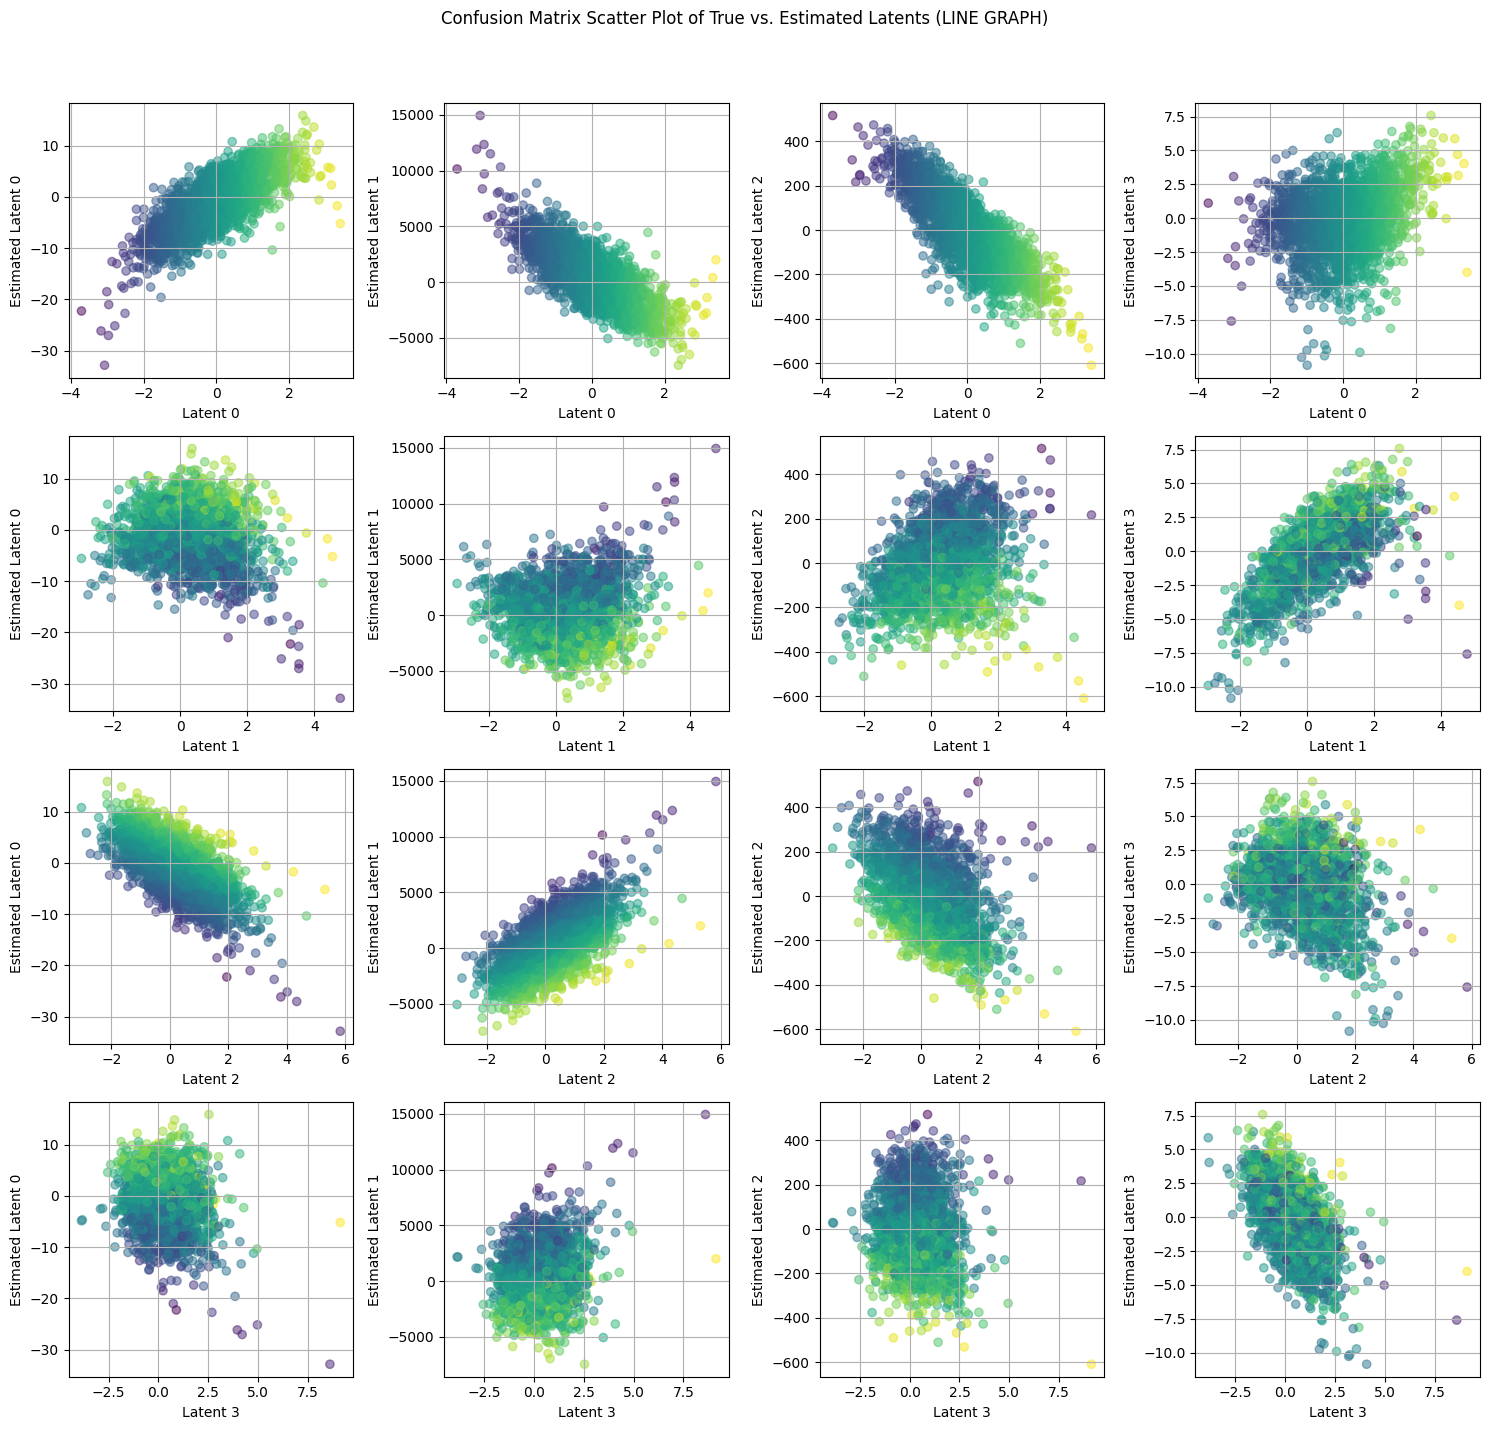

In [19]:
U_np = U.detach().numpy()
# X_np = X.detach().numpy()
fig, axes = plt.subplots(nrows=num_latent, ncols=num_latent, figsize=(15, 15))
# Set a title for the figure
fig.suptitle('Confusion Matrix Scatter Plot of True vs. Estimated Latents (LINE GRAPH)')

# Iterate over each combination of columns in A and B
for i in range(num_latent):
    for j in range(num_latent):
        ax = axes[i, j]
        ax.scatter(U_np[:, i], id_layers[:, j], alpha=0.5,  c = U_np[:,0])  # Plotting the scatter plot
        ax.set_xlabel(f'Latent {i}')  # Set x-axis label
        ax.set_ylabel(f'Estimated Latent {j}')  # Set y-axis label
        ax.grid(True)  # Optional: Adds grid to the plots for better visibility

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

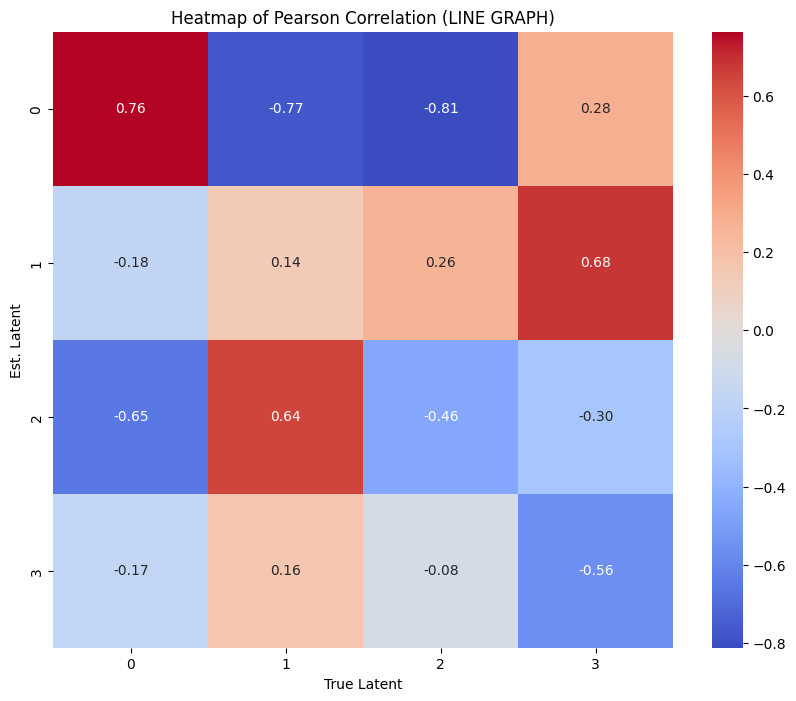

In [20]:
#Pearson Correlation
#Mutual Information
#RMSE

results = []

for i in range(num_latent):
    for j in range(num_latent):
        # Calculate metrics
        pearson_corr = np.corrcoef(U_np[:, i], id_layers[:, j])[0, 1]
        mutual_info = mutual_info_regression(U_np[:, i].reshape(-1, 1), id_layers[:, j])[0]
        rmse = np.sqrt(mean_squared_error(U_np[:, i], id_layers[:, j]))

        # Append the results as a dictionary to the results list
        results.append({
            'Est. Latent': i,
            'True Latent': j,
            'Pearson Correlation': pearson_corr,
            'Mutual Information': mutual_info,
            'RMSE': rmse
        })

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# # Print the DataFrame using tabulate for a nicer format
# print(tabulate(df_results, headers='keys', tablefmt='pipe', showindex=False))

pivot_df = df_results.pivot(index='Est. Latent', columns='True Latent', values='Pearson Correlation')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Pearson Correlation (LINE GRAPH)')
plt.show()

# Y-Structure

In [98]:
DAG_type = 'line'
num_latent = 4
num_samples = 2000
variance_max = 1
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat

In [99]:
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
graph = SyntheticDAG(num_latent, DAG_type, variance_max)
graph.DAG.add_arc(1,3)
graph.DAG.remove_arc(2,3)

there are no undirected edges
plotting...


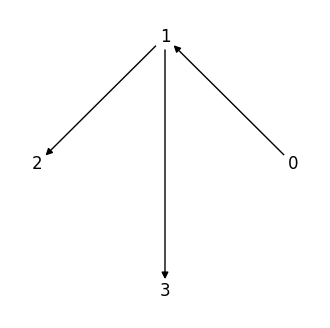

In [100]:
graph.draw_graph()

In [44]:
U,X=graph.get_obs_samples(G, num_samples, rescale=False)
U_tr,X_tr =graph.get_obs_samples(G, 100000, rescale=False)
# U = graph.get_samples(num_samples)
# U_tr, = graph.get_samples(100000)
# X = (G@U.T).Ta
# X_tr = (G@U_tr.T).T


In [45]:
torch.var(U,dim=0)

tensor([1.0142, 1.1769, 1.1575, 1.3785], grad_fn=<VarBackward0>)

In [103]:
id_layers = identify_e(X, X_tr, estimator='ssm')
# id_layers = identify(graph, U, G)

-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Threshold:  0.19325330949711464
Optimal solution found:
[ 0.         -0.0709457  -0.50249378 -0.86744839]

Optimal solution found:
[ 0.69549652  0.38221052  0.51947624 -0.33218088]

No feasible solution found.
Done.

Peeled off 2 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Threshold:  0.21050544964268897
Optimal solution found:
[-0.1642522   0.99147426]

No feasible solution found.
Done.

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Peeled off 1 nodes.


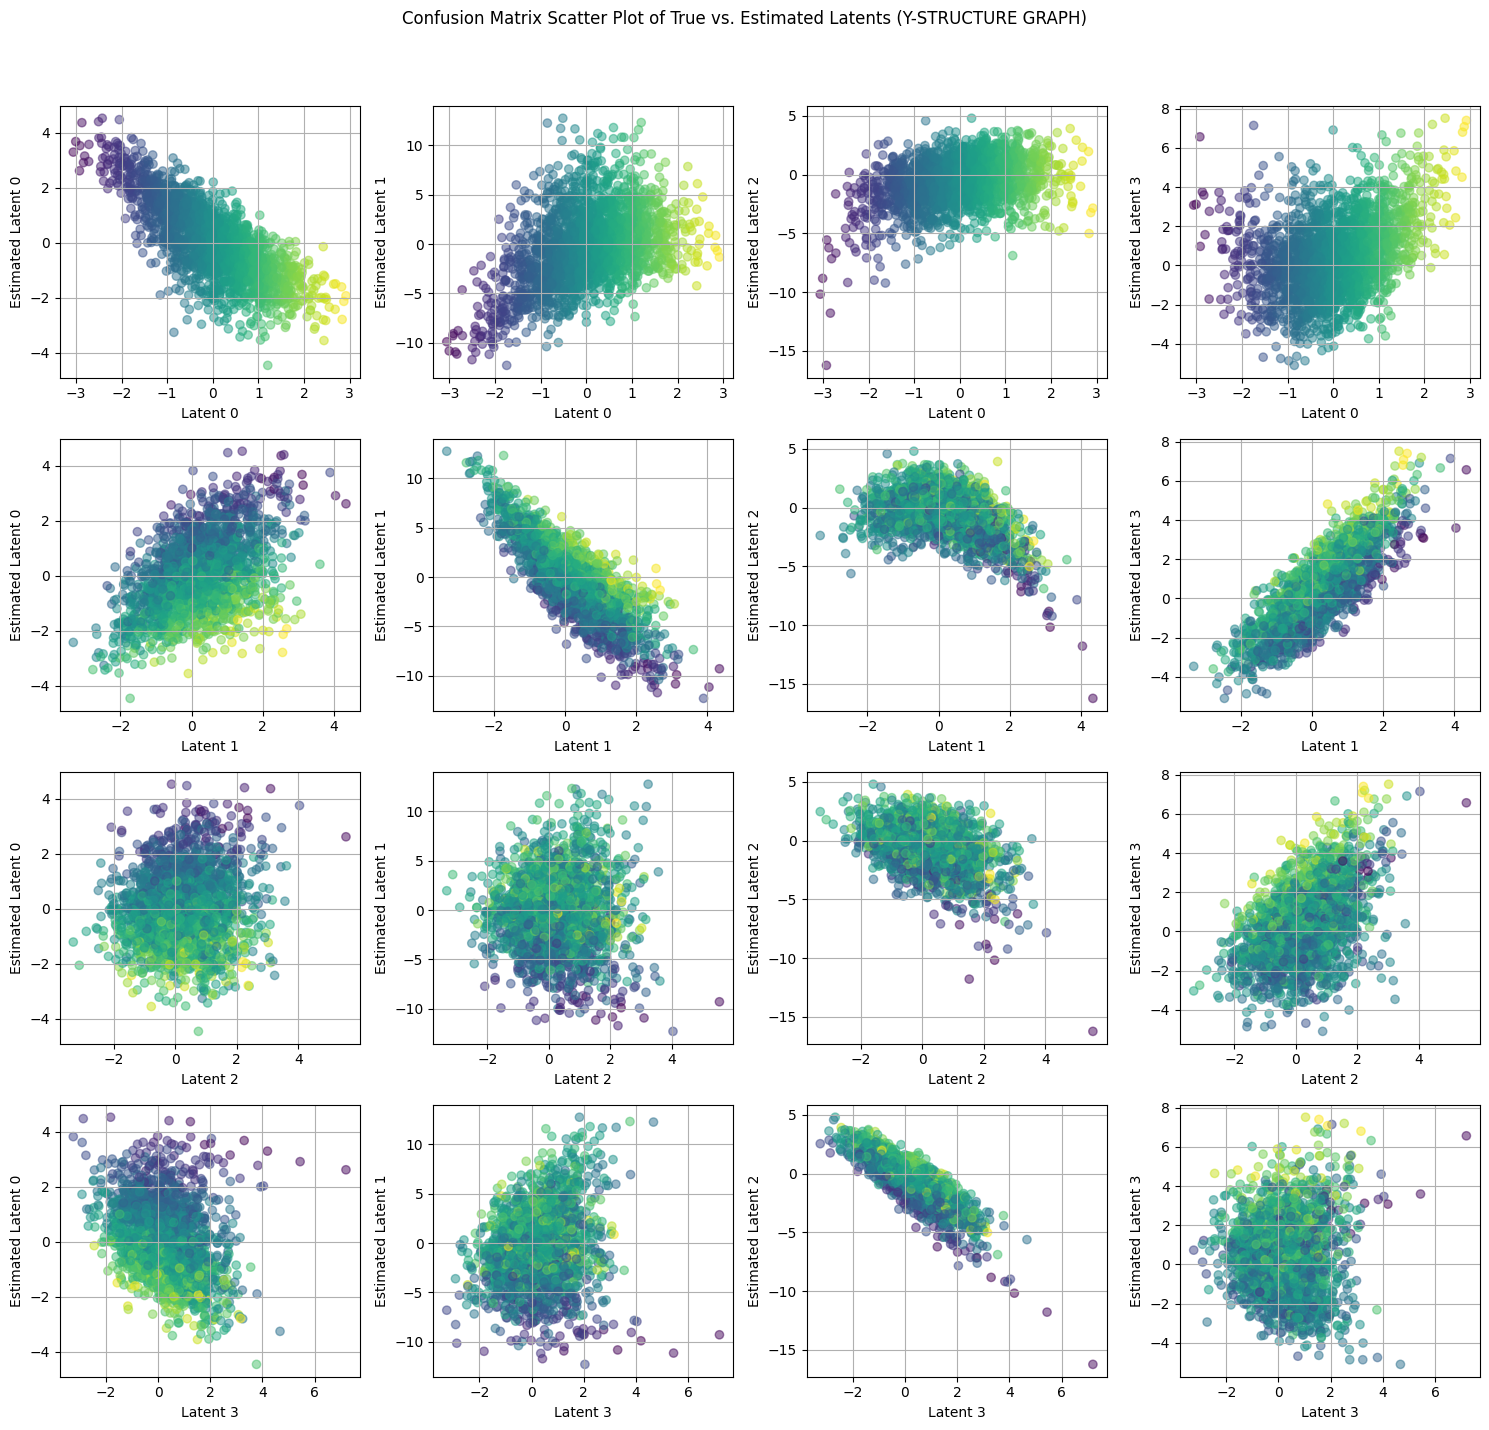

In [106]:
U_np = U.detach().numpy()
fig, axes = plt.subplots(nrows=num_latent, ncols=num_latent, figsize=(15, 15))
# Set a title for the figure
fig.suptitle('Confusion Matrix Scatter Plot of True vs. Estimated Latents (Y-STRUCTURE GRAPH)')

# Iterate over each combination of columns in A and B
for i in range(num_latent):
    for j in range(num_latent):
        ax = axes[i, j]
        ax.scatter(U_np[:, i], id_layers[:, j], alpha=0.5,  c = U_np[:,0])  # Plotting the scatter plot
        ax.set_xlabel(f'Latent {i}')  # Set x-axis label
        ax.set_ylabel(f'Estimated Latent {j}')  # Set y-axis label
        ax.grid(True)  # Optional: Adds grid to the plots for better visibility

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

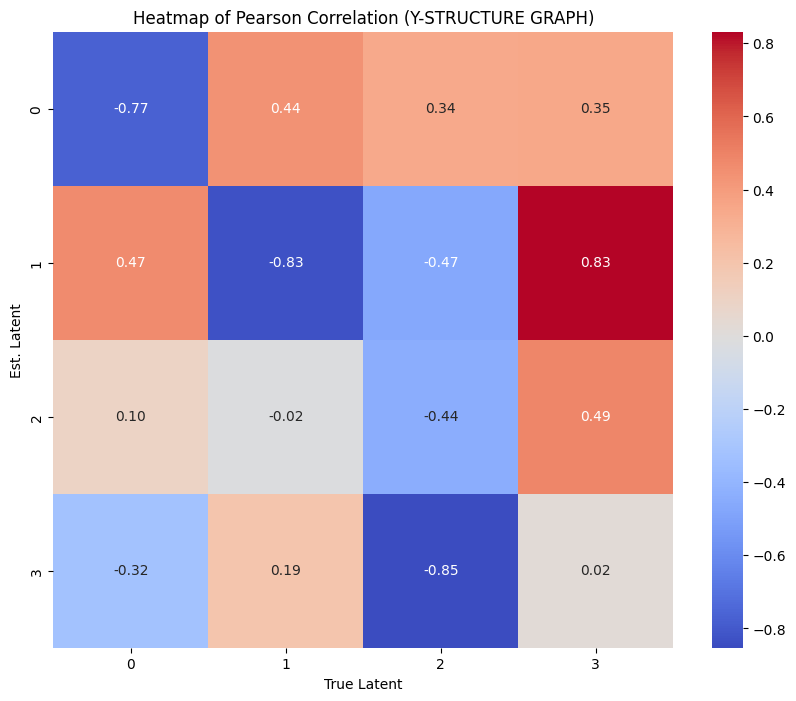

In [107]:
results = []

for i in range(num_latent):
    for j in range(num_latent):
        # Calculate metrics
        pearson_corr = np.corrcoef(U_np[:, i], id_layers[:, j])[0, 1]
        mutual_info = mutual_info_regression(U_np[:, i].reshape(-1, 1), id_layers[:, j])[0]
        rmse = np.sqrt(mean_squared_error(U_np[:, i], id_layers[:, j]))

        # Append the results as a dictionary to the results list
        results.append({
            'Est. Latent': i,
            'True Latent': j,
            'Pearson Correlation': pearson_corr,
            'Mutual Information': mutual_info,
            'RMSE': rmse
        })

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# # Print the DataFrame using tabulate for a nicer format
# print(tabulate(df_results, headers='keys', tablefmt='pipe', showindex=False))

pivot_df = df_results.pivot(index='Est. Latent', columns='True Latent', values='Pearson Correlation')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Pearson Correlation (Y-STRUCTURE GRAPH)')
plt.show()

# Barbasi Albert

In [4]:
DAG_type = 'barabasialbert'
num_latent = 4
num_samples = 3000
variance_max = 1
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat

there are no undirected edges
plotting...


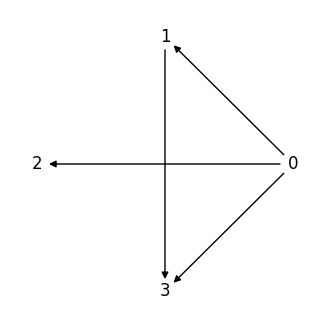

In [22]:
# G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
graph = SyntheticDAG(num_latent, DAG_type, variance_max)
graph.draw_graph()
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)

In [23]:
U,X = graph.get_obs_samples(G, num_samples)
# U_tr,X_tr = graph.get_obs_samples(G, 100000)
# U_tr = graph.get_samples(100000)
# X = (G@U.T).T
# X_tr = (G@U_tr.T).T
# id_layers = identify_e(X, X_tr, estimator='ssm')
id_layers = identify(graph, U, G)

-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[ 0.12020409 -0.44986703  0.81154371  0.33634536]

Optimal solution found:
[ 0.00496706 -0.66380521 -0.54430034  0.42367872]

No feasible solution found.
Done.

U_hat as a linear combination of U:
[[ 3.93227166e-01 -6.40173328e-01  1.68818879e+00  4.18148019e-01]
 [ 1.66221452e+00  2.10201660e+00 -8.85352872e-01  1.09099526e+00]
 [ 2.72577728e+00  4.38614381e+00  8.29918070e-04 -1.02240728e-03]
 [-2.65690840e+00 -3.01103236e+00 -8.01505785e-04  9.87498799e-04]]

Peeled off 2 nodes.
-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[ 0.86501989 -0.59307834]

No feasible solution found.
Done.

U_hat as a linear combination of U:
[[ 3.58789472e+00  5.07266884e+00]
 [-6.50074896e-01 -3.12417855e-03]]

Peeled off 1 nodes.
-----------------------------------------------------------
Removing Layer 3.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2


INFO:gurobipy:Set parameter NonConvex to value 2


Optimal solution found:
[-1.04880885]

No feasible solution found.
Done.

U_hat as a linear combination of U:
[[0.6198221]]

Peeled off 1 nodes.


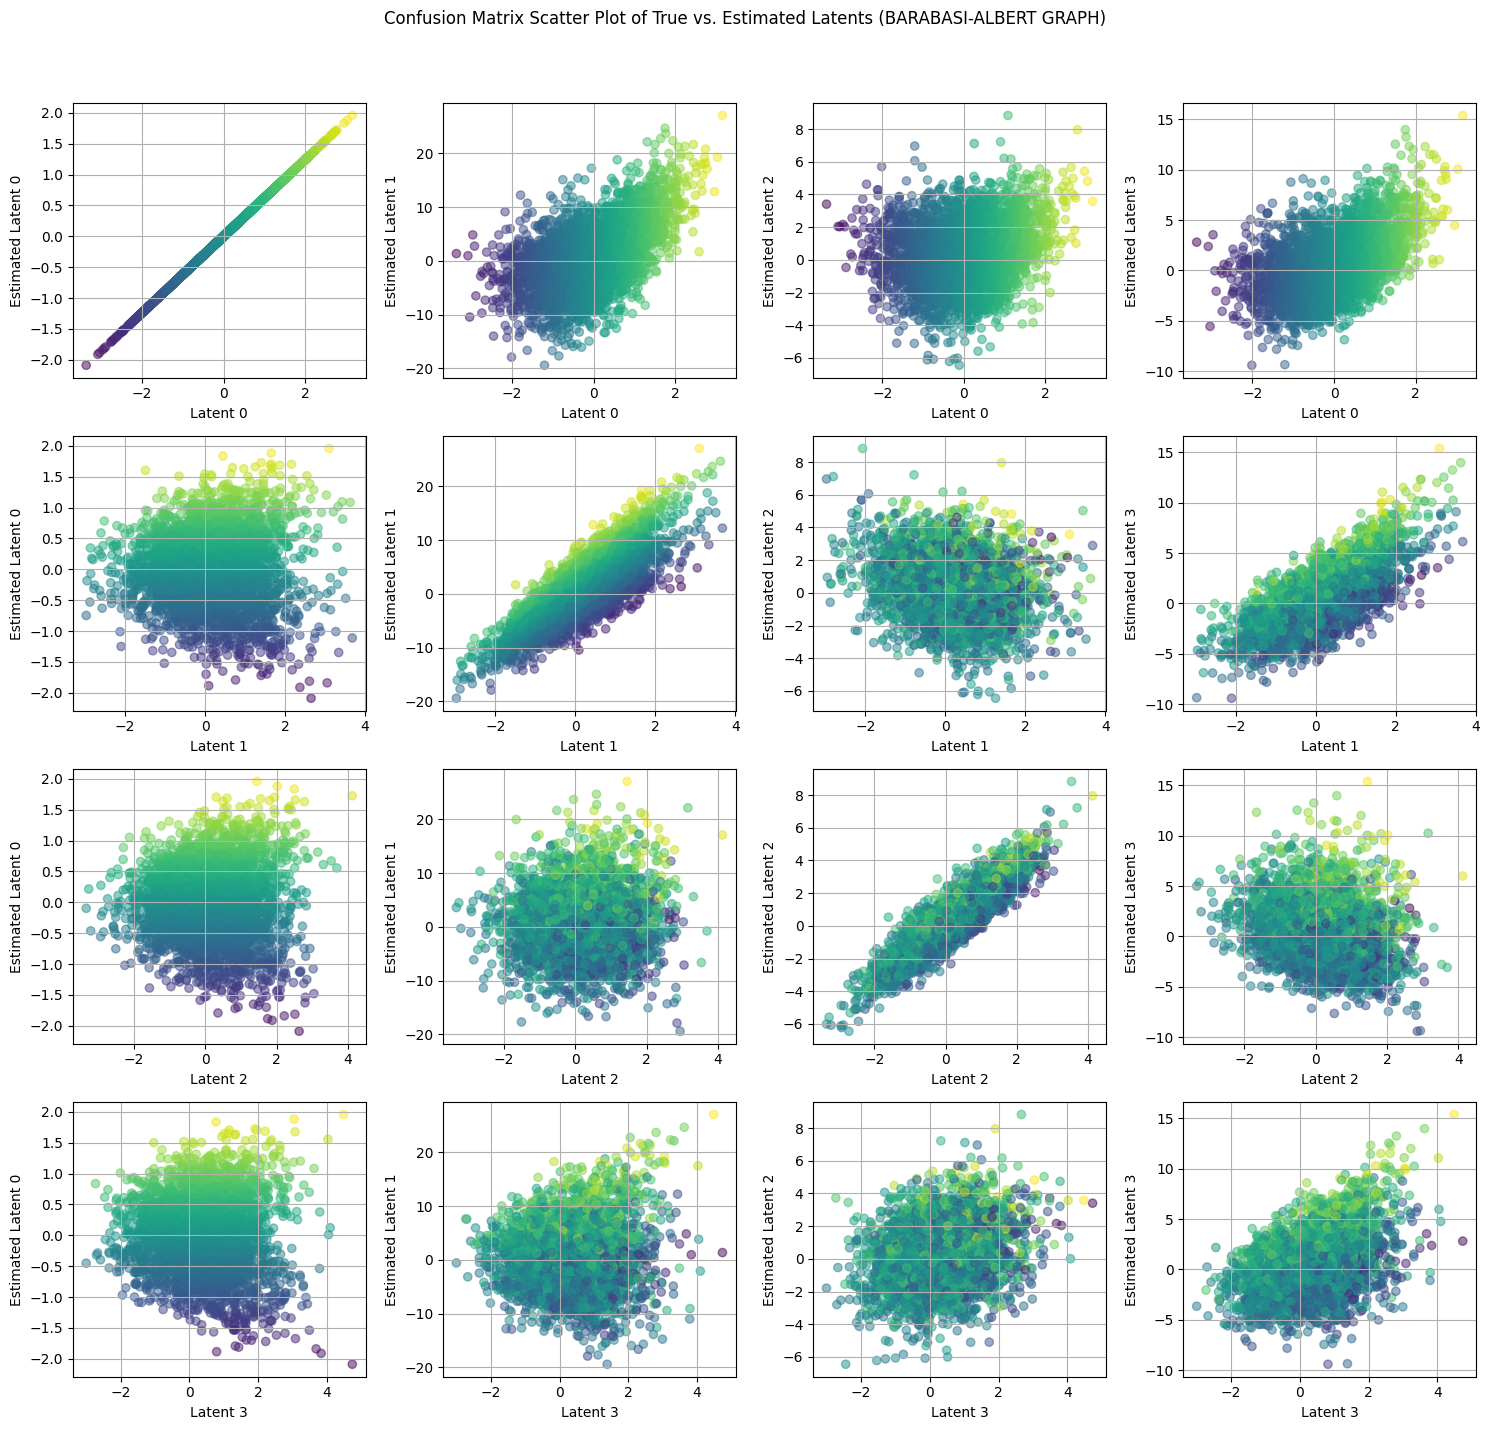

In [24]:
U_np = U.detach().numpy()
fig, axes = plt.subplots(nrows=num_latent, ncols=num_latent, figsize=(15, 15))
# Set a title for the figure
fig.suptitle('Confusion Matrix Scatter Plot of True vs. Estimated Latents (BARABASI-ALBERT GRAPH)')

# Iterate over each combination of columns in A and B
for i in range(num_latent):
    for j in range(num_latent):
        ax = axes[i, j]
        ax.scatter(U_np[:, i], id_layers[:, j], alpha=0.5,  c = U_np[:,0])  # Plotting the scatter plot
        ax.set_xlabel(f'Latent {i}')  # Set x-axis label
        ax.set_ylabel(f'Estimated Latent {j}')  # Set y-axis label
        ax.grid(True)  # Optional: Adds grid to the plots for better visibility

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

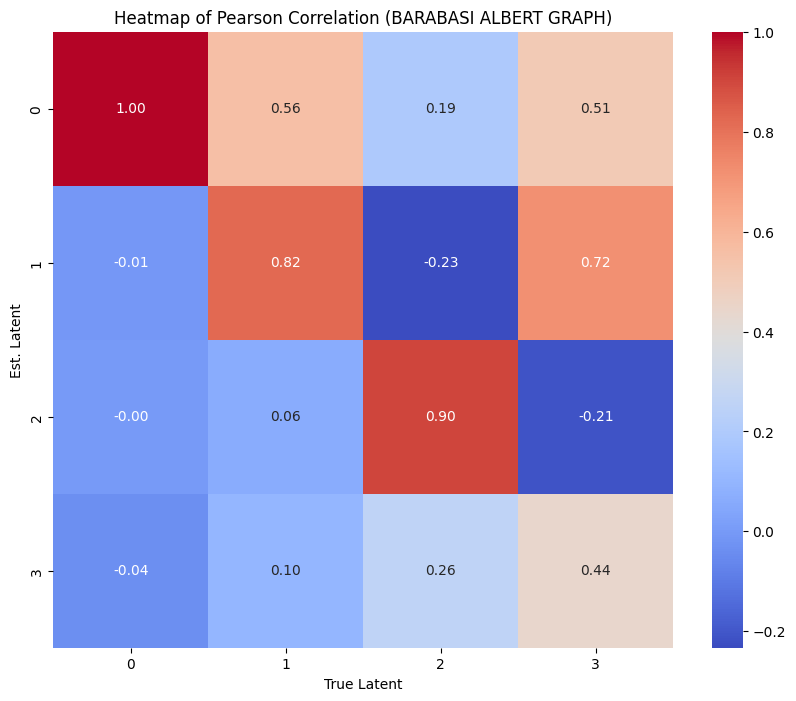

In [25]:
results = []

for i in range(num_latent):
    for j in range(num_latent):
        # Calculate metrics
        pearson_corr = np.corrcoef(U_np[:, i], id_layers[:, j])[0, 1]
        mutual_info = mutual_info_regression(U_np[:, i].reshape(-1, 1), id_layers[:, j])[0]
        rmse = np.sqrt(mean_squared_error(U_np[:, i], id_layers[:, j]))

        # Append the results as a dictionary to the results list
        results.append({
            'Est. Latent': i,
            'True Latent': j,
            'Pearson Correlation': pearson_corr,
            'Mutual Information': mutual_info,
            'RMSE': rmse
        })

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# # Print the DataFrame using tabulate for a nicer format
# print(tabulate(df_results, headers='keys', tablefmt='pipe', showindex=False))

pivot_df = df_results.pivot(index='Est. Latent', columns='True Latent', values='Pearson Correlation')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Pearson Correlation (BARABASI ALBERT GRAPH)')
plt.show()

In [60]:
def get_samples_(num_samples=10, nnodes=4):
    U = torch.zeros(num_samples, nnodes)
    U[:,0] = torch.randn(num_samples)
    # for 

In [61]:
get_samples_()

tensor([[-0.5430,  0.0000,  0.0000,  0.0000],
        [-0.0938,  0.0000,  0.0000,  0.0000],
        [ 0.4436,  0.0000,  0.0000,  0.0000],
        [-0.9673,  0.0000,  0.0000,  0.0000],
        [ 0.2042,  0.0000,  0.0000,  0.0000],
        [ 1.7451,  0.0000,  0.0000,  0.0000],
        [-0.0309,  0.0000,  0.0000,  0.0000],
        [ 1.7869,  0.0000,  0.0000,  0.0000],
        [-1.6181,  0.0000,  0.0000,  0.0000],
        [ 0.3856,  0.0000,  0.0000,  0.0000]])